In [43]:
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from random import randint
from collections import Counter 
import collections
import statistics
import time
from itertools import chain 
import random
import operator
import copy

In [44]:
random.seed(42) 

### Importing and exploring data 

In [45]:
dataset = pd.read_csv('wikigraph_reduced.csv', sep='\t', 
                      delimiter=None, header='infer',
                      names=None, index_col=None, 
                      usecols=None, 
                      encoding = "ISO-8859-1")
dataset.head()

,Unnamed: 0,0,1
0,796,95,1185516
1,909,108,1059989
2,910,108,1062426
3,911,108,1161925
4,1141,134,541222


In [46]:
dataset.columns=['Index','Source','Target']

In [47]:
# check if index columns has unique values
print(len(dataset.Index))
print(len(set(dataset.Index)))

483094
483094


In [48]:
dataset.set_index('Index' , inplace = True)
dataset.head()

,Source,Target
Index,,
796,95,1185516
909,108,1059989
910,108,1062426
911,108,1161925
1141,134,541222


#### Associate single category to each node

In [49]:
# all nodes in and out
unique_nodes = set(set(dataset.Source).union(set(dataset.Target)))
n_nodes = len(unique_nodes)
n_edges = len(dataset)

In [50]:
category_file = 'wiki-topcats-categories.txt'

Non filtered categories

In [51]:
categories_all = {v: [] for v in unique_nodes}
no_category = []

with open(category_file) as file:
    for i in range(17364):
        line = file.readline()
        category = line.split(';')[0].split(':')[-1]
        nodes = line.split(';')[1].split(' ')[1:-2]
        
        for node in nodes:
            try:
                categories_all[int(node)].append(category)
            except:
                no_category.append(int(node))

Filtering categories

In [52]:
nodes_category = {}
for n in categories_all.keys():
    try:
        rand_category = random.choice(categories_all[n])
        nodes_category[n] = rand_category
    except:
        nodes_category[n] = None

In [53]:
category_nodes = {category:[] for category in set(nodes_category.values())}
for node in nodes_category.keys():
    try:
        category_nodes[nodes_category[node]].append(node)
    except:
        continue

#### Create graph

In [54]:
in_links = {v: [] for v in set(dataset.Target)}
out_links = {v: [] for v in set(dataset.Source)}

for row in dataset.iterrows():
    source = row[1][0]
    target = row[1][1]
    in_links[target].append(source)
    out_links[source].append(target)

In [55]:
n_art_outlink = len(out_links)
n_art_inlink = len(in_links)

In [56]:
out_links[108]

[1059989, 1062426, 1161925]

#### Check if directed

In [240]:
directed = False
for node in in_links:
    if len(set(in_links[node]).intersection(set(out_links[node]))) != 0:
        directed = True
        break
if directed:
    print('Graph is directed')
else:
    print('Graph is undirected')

Graph is directed


In [241]:
# undirected version of the graph
links = in_links.copy()
links.update(out_links)

#### Density

In [242]:
density = (n_edges/(n_nodes*(n_nodes-1)))
avarage = n_edges/n_nodes

print('Graph density is:',density)
print('Graph hyperliks avarage is:',avarage)

Graph density is: 4.9951571365597335e-05
Graph hyperliks avarage is: 4.912337431235573


#### Visualize the nodes' degree distribution

In [74]:
my_len = [] 
for node in links.keys():
    my_len.append(len(links[node]))

# dictionary with degree
node_degree = dict(zip(links.keys(), my_len))
d = Counter(node_degree)

In [75]:
# degree distribution
counter_supp = list()
for i in range(1, max(my_len)):
    counter_supp.append(my_len.count(i))
counter_supp = [c/max(counter_supp) for c in counter_supp]

In [76]:
# cumulative degree ditribution
counter = [0]
for i in range(1, max(my_len)):
    counter.append(counter[-1]+my_len.count(i))
counter = [c/max(counter) for c in counter]

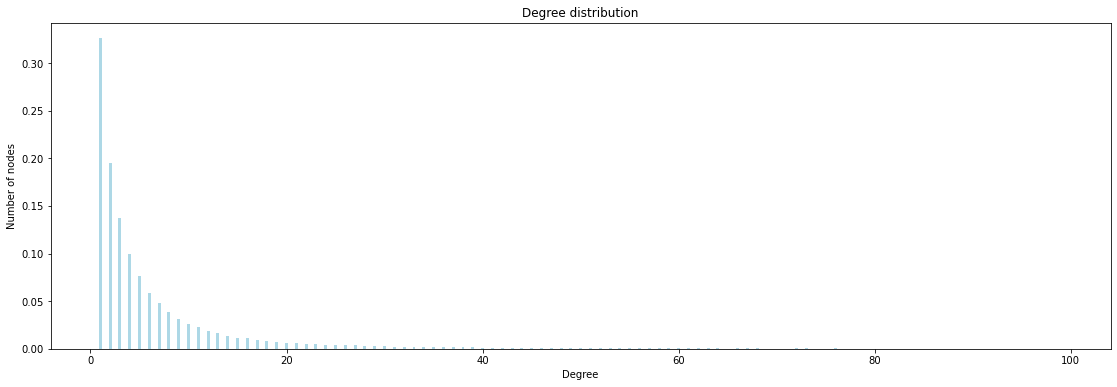

In [20]:
plt.figure(figsize = (19,6))
plt.bar(x = list(range(1,len(counter_supp[1:100])+1)),height = counter_supp[1:100],color = 'lightblue',width = 0.3);
plt.ylabel('Number of nodes')
plt.xlabel('Degree')
plt.title('Degree distribution')
plt.show()

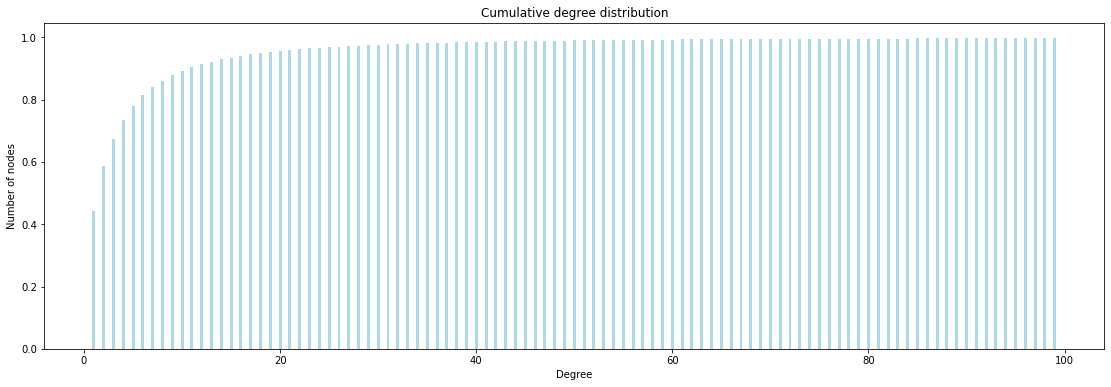

In [21]:
plt.figure(figsize = (19,6))
plt.bar(x = list(range(1,len(counter[1:100])+1)),height = counter[1:100],color = 'lightblue',width = 0.3);
plt.ylabel('Number of nodes')
plt.xlabel('Degree')
plt.title('Cumulative degree distribution')
plt.show()

### In and out degree

In [243]:
in_d = [] 
for node in in_links.keys():
    in_d.append(len(in_links[node]))

in_degree = dict(zip(in_links.keys(), in_d)) # dictionary with in-degree

In [244]:
out_d = [] 
for node in out_links.keys():
    out_d.append(len(out_links[node]))

out_degree = dict(zip(out_links.keys(), out_d)) # dictionary with out-degree

### Useful Functions

In [14]:
def explore(node,limit):
   
    ''' This function takes as an input one node and a click limit.
    Limit can be set to None if we don't want any limit.
    The function returns a dictionary where keys are distances and values are all the nodes 
    which are at distance d (key) from the input node'''
    
    # initializing variables
    distance_tree = {}
    explored = set()
    clicks = 1 
    
    # checking if node has at list one outlink
    try:
        out_nodes = set(out_links[node])
    except:
        print('No out-link from', node)
        return distance_tree
    
    '''
    1. We iterate until the new set of out-nodes to explore is non-empty 
    2. For each iteration we only consider unexplored nodes
    3. If the node is a key in out_links, we add the set of nodes associated to it to the new set of nodes
    4. We update all variables and increase distance by one'''

    while out_nodes != set(): 
        
        if limit != None:
            if clicks > limit+1:        
                return distance_tree
        
        distance_tree[clicks] = out_nodes
        new_out_nodes = set() 
        
        for node in out_nodes: 
            try:
                new_out_nodes = new_out_nodes.union(set(out_links[node])) 
            except:
                continue
        
        explored = explored.union(out_nodes) 
        out_nodes = new_out_nodes.difference(explored)
        clicks += 1 
    
    return distance_tree

In [15]:
def shortest_path (node1,node2):
    
    ''' This function takes in input two nodes and returns the length of the shortest path.
    If node 1 does not have any outlink or if no path is found between node 1 and node 2, None is returned. '''
    
    # exeptions
    if node1 == node2:
        return 0, []
    
    # set of outnodes of node 1
    try:
        out_nodes = set(out_links[node1]) 
    except:
        print('No out-link from', node1)
        return 'Inf', []
    
    # initializing explored nodes set and minimum distance
    explored = set() 
    clicks = 1
    parents =  {node : {1:[node1]} for node in out_nodes}
    
    ''' ITERATIONS: we iterate until we find node 2. In the case in which we have not found node 2 
    but we don't have any new node to explore, we assume the two nodes are disconnected.
    
    1. We check the new set of out-nodes to explore is non-empty 
    2. We iterate through unexplored nodes
    3. If the node is a key in out_links, we add the set of nodes associated to it to the 
    new set of nodes in order to proceed with exploration
    4. In order to retrieve the actual set of nodes met to get from node1 to node2,
    for each explored node we save its parent (or parents) at each iteration and retrace the path
    backwards from node2 to node 1.'''
   
    while node2 not in parents.keys(): 
        clicks += 1 
        
        if out_nodes != set(): 
            new_out_nodes = set() 

            for node in out_nodes:  
                try:
                    new_out_nodes = new_out_nodes.union(set(out_links[node]))
                    for new_node in out_links[node]:
                        if new_node in parents.keys():
                            if clicks in parents[new_node]:
                                parents[new_node][clicks].append(node)
                            else:
                                parents[new_node].update({clicks:[node]})
                        else:
                            parents[new_node] = {clicks:[node]}
                except:
                    continue

            explored = explored.union(out_nodes)
            out_nodes = new_out_nodes.difference(explored) 
    
        else: 
            print('No path found')
            return 'Inf', []
    
    path = [node2]
    while path[-1] != node1:
        path = get_reversed_path(parents,clicks,node2)
    
    return clicks, [node2]+path

In [16]:
def get_reversed_path(parents, dist, node):
    
    '''we iterate backwards from node2 to node1 through the parents dictionary until we find node1 
    at distance "clicks" from node 2. In the case of branched path we explore them randomly untile we 
    find the one we are interested in.'''
    
    path = []
    for i in reversed(range(1,dist+1)):
        parent_list = parents[node][i]
        if len(parent_list) > 1:
            index = random.randint(0,len(parent_list)-1)
            parent = parent_list[index]
        else:
            parent = parent_list[0]
        path.append(parent)
        node = parent
    
    return path

In [22]:
node2 = 1161925
node3 = 134

In [23]:
sp,path = shortest_path(node3,node2)
print('Shortest path between', node3, 'and', node2, 'is', path, 'which requires', sp, 'clicks')

Shortest path between 134 and 1161925 is [1161925, 1056157, 1165599, 1061485, 134] which requires 4 clicks


In [24]:
tree = explore(node3,None)
print('Exploration tree of node', node3, 'has max distance', max(tree.keys()))

Exploration tree of node 134 has max distance 15


In [50]:
links[108]

[1059989, 1062426, 1161925]

## RQ2

In [25]:
def get_articles(node,n_clicks):
    '''This function works as the explore function defined above, but with a different output format.'''
    tree = explore(node_id,n_clicks)
    articles = []
    for d in tree.keys():
        articles+=tree[d]
    return articles

In [26]:
start = time.time()
n_clicks = 4
node_id = 134
articles = get_articles(node_id,n_clicks)
print('Execution time: ', (time.time() - start)/60, 'minutes')
print('Number of articles reached within', n_clicks, 'from node', node_id,':', len(articles))

Execution time:  0.42510937054951986 minutes
Number of articles reached within 4 from node 134 : 44717


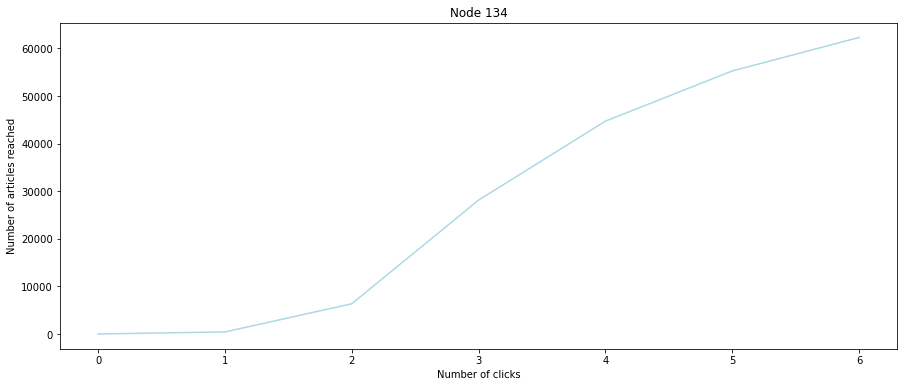

In [27]:
graph = []
for n_clicks in range(7):
    graph.append(len(get_articles(node_id,n_clicks)))
plt.figure(figsize = (15,6))
plt.plot(graph,color = 'lightblue');
plt.ylabel('Number of articles reached')
plt.xlabel('Number of clicks')
plt.title(f'Node {node_id}')
plt.show()

## RQ3

In [128]:
def set_of_pages(l):
    l_index = randint(0, len(l) - 1)
    r_index = randint(l_index + 1, len(l))
    return l[l_index:r_index]

In [175]:
def get_next(start, p, tree, out_deg_p):
        
    ''' We want to sort all nodes left to visit by their distance from the starting node, in decreasing order.
    The nodes are sorted in this way to be more time efficient, since we avoid to look two times for the same 
    shortest path.
    1. We create a set of nodes that we want to find and generate the exploration tree of our start node.
    2. We iterate all the distances in the tree and if we find any of the nodes of interest we save them 
    in a dictionary.
    3. We get the list of nodes nodes to be visited sorted by furthest to the nearest. '''
    
    p_decreasing = sort_nodes(tree, p)
    if p_decreasing ==[]:
        print('Nodes', p, 'cannot be reached from node', start)
        return None, [], set()
    
    print('Nodes to visit', len(p_decreasing))
        
    ''' Now we want to get all shortest paths from start node to any other node left to visit. 
    1. We have a set of nodes to visit to be iterated in a specific order. We always pick the one which is 
    further away from the start node (element 0).
    2. We save the shortest path to this node in a dictionary, remove the node from the list of nodes to visit 
    and save the nodes that we have met along the path if they are in the set of nodes to visit.
    3. We remove all the other nodes of interest met along the way from the set of nodes to visit. 
    
    notice: we alredy know that these nodes will not have the greatest number of crossed nodes '''
    
    rel_path, crossed = get_paths(p_decreasing, p, start)
    
    ''' Among all nodes that are left to visit we pick as "next" according to this features:
    1. We check the node that maximises the number of crossed nodes. However if the outdegree of this node is 
    zero we check if we have any othe node to visit, if yes, we discard this node.
    2. If two nodes cross the same number of nodes, we pick the one with higher outdegree.
    3. If two nodes cross the same number of nodes and have equal outdegree, we pick the closer one'''
    
    best_node = p_decreasing[0]
    max_crossed = len(crossed[best_node])
    
    for node in crossed.keys():
        if len(crossed[node]) > max_crossed:
            if out_deg_p[node] == 0:
                if p - set(rel_path[node]+[best_node]) == set():
                    best_node = node
                    max_crossed = len(crossed[node])
            else:
                best_node = node
                max_crossed = len(crossed[node])

        elif len(crossed[node]) == max_crossed:          
            if out_deg_p[node] > out_deg_p[best_node] : 
                    best_node = node
            elif len(crossed[node]) > len(crossed[best_node]):
                best_node = node

    if rel_path[best_node] == []:
        print('Cannot reach', best_node)
    else:
        print('Path to', best_node, ':', rel_path[best_node])
    
    return best_node, rel_path[best_node], set(rel_path[best_node]+[best_node])

In [176]:
def sort_nodes(tree, p):
    
    distances = {}
    to_find = set(copy.copy(p))
    for d in tree.keys():
        visited = set(tree[d]).intersection(to_find)
        distances[d] = visited                 
    
    p_decreasing = collections.OrderedDict(sorted(distances.items()))
    p_decreasing = list(chain.from_iterable(list(p_decreasing.values())))
        
    return p_decreasing

In [177]:
def get_paths(p_decreasing, p, start):
    
    rel_path = {node:[] for node in p}
    crossed = {node:[] for node in p}
    to_visit = copy.copy(p_decreasing)
    
    while len(to_visit) > 1:
        node = to_visit[0]
        clicks,path = shortest_path(start, node)
        rel_path[node] = path
        crossed_list = set(path).intersection(set(to_visit)) 
        crossed[node] = crossed_list 
        to_visit.remove(node)
        for node_a in crossed_list:
            if node_a in to_visit:
                to_visit.remove(node_a)
                
    return rel_path, crossed

In [184]:
def visit_all(C):
    
    ''' PRIMARY STEPS :
    1. We retrieve the set of nodes in C
    2. We find the center and check that it exists (meaning that at list one node has a non zero in-degree)
    3. We check that at most one node has outdegree 0'''
    
    p = copy.copy(category_nodes[C])
    max_indeg = 0
    out_deg_p = {}
    center = ''
    
    for node in p:
        if node in in_links.keys():    
            if len(in_links[node]) > max_indeg:
                center = node
                max_indeg = len(in_links[node])
        try:
            out_deg_p[node] = len(out_links[node])
        except:
            out_deg_p[node] = 0
    
    zero_outdeg = list(out_deg_p.values()).count(0)
    
    p = set_of_pages(p)
    print('Nodes to visit', p)
    
    if center == '' or zero_outdeg > 1:
        print('More than one node has outdegree zero')
        return 'Not possible'
    elif center in p:
        p.remove(center)
    
    print('Center is node', center, 'with indegree', max_indeg)
    
    ''' SECONDARY STEPS :
    Now we apply the "get_next" function until we either find all nodes or we are stuck for two consecutive
    iterations at the same node'''
    
    start = center
    exploration = [center]
    to_visit = set(copy.copy(p))
    
    while len(to_visit) >= 1:
        tree = explore(start, None)
        next_node, path, visited = get_next(start,to_visit,tree,out_deg_p)
        if next_node == start or next_node == None or path == []:
            return 'Not possible'
        exploration += path + [next_node]
        to_visit =  to_visit - visited
        start = next_node
    
    return exploration, p+[center]

In [186]:
start = time.time()
res2 = visit_all('Deaths_from_diabetes')
print('Running time:', time.time() - start)

Nodes to visit [573108, 79498, 1163472, 1163624, 1224657]
Center is node 573108 with indegree 148
Nodes to visit 4
Path to 1163472 : [1163472, 1163692, 1025350, 573108]
Nodes to visit 3
Path to 1163624 : [1163624, 1163657, 1163472]
Nodes to visit 2
Path to 1224657 : [1224657, 1056673, 1169416, 1063005, 1163624]
Nodes to visit 1
Cannot reach 79498
Running time: 59.33351802825928


In [38]:
start = time.time()
res3 = visit_all('Republic_of_Ireland_international_footballers')
print('Running time:', start - time.time())
print(len(res3))

Center is node 82484 with indegree 9
Nodes to visit [84115, 81108, 83662, 84000, 82809, 82891, 84621, 76919]
Next node to visit is: 82891
Path to 82891 : [82891, 81875, 82350, 81942, 83114, 82484]
Nodes to visit [82809, 84115, 84000, 81108, 83662, 84621, 76919]
Next node to visit is: 82809
Path to 82809 : [82809, 81856, 82891]
Nodes to visit [84115, 81108, 84000, 84621, 83662, 76919]
Next node to visit is: 84000
Path to 84000 : [84000, 81152, 82762, 80244, 82809]
Nodes to visit [84115, 81108, 83662, 84621, 76919]
Next node to visit is: 81108
Path to 81108 : [81108, 81858, 81774, 84000]
Nodes to visit [84115, 83662, 84621, 76919]
Next node to visit is: 84115
Path to 84115 : [84115, 81856, 81858, 81108]
Nodes to visit [84621, 83662, 76919]
Next node to visit is: 83662
Path to 83662 : [83662, 82779, 81934, 82981, 82551, 83759, 84115]
Nodes to visit [84621, 76919]
Next node to visit is: 84621
Path to 84621 : [84621, 80827, 83306, 81373, 83662]
Nodes {76919, 92583} cannot be reached from no

In [39]:
start = time.time()
res4 = visit_all('Films_shot_in_New_Mexico')
print('Running time:', start - time.time())
print(len(res4))

Center is node 1063044 with indegree 26
Nodes to visit [1060976, 1065124, 1064839, 1063181, 1060110, 1067505, 1063220, 1083965, 1056128, 1227201, 1015488, 1065765, 135047, 48977, 1062975]
Next node to visit is: 1063220
Path to 1063220 : [1063220, 1061501, 1062053, 1063044]
Nodes to visit [1227201, 1060976, 1065124, 1060110, 1056128, 1065765, 135047, 1064839, 1063181, 1067505, 48977, 1083965, 1062975, 1015488]
Next node to visit is: 1062975
Path to 1062975 : [1062975, 1061214, 1061886, 1061783, 1063220]
Nodes to visit [1060976, 1063181, 1227201, 1065124, 1065765, 1056128, 1015488, 1064839, 135047, 1060110, 1067505, 48977, 1083965]
Next node to visit is: 1060976
Path to 1060976 : [1060976, 1060722, 1062975]
Nodes to visit [1060110, 1083965, 1056128, 1227201, 1015488, 1065124, 1065765, 1064839, 135047, 1063181, 1067505, 48977]
Next node to visit is: 1083965
Path to 1083965 : [1083965, 1163761, 1060975, 1060976]
Nodes to visit [1064839, 1015488, 1227201, 1065124, 1065765, 1063181, 1060110,

## RQ5

For this task we will use a function that, given a category name in input (C0), will return the shortest path from C0 to any other category in the graph. According to our interpretation of the task, we should not consider the path from the destination category (Ci) to C0, rather we should only consider the path from nodes in C0 to Ci. Consequently, even if two nodes (n0 $\in$ C0 and ni $\in$ Ci) are not disconnected, we will still assume they are if a directional path from n0 to ni does not exist.

In our function *categories_distance* we follow these steps:
  1. we consider the exploration tree of each node in C0 thorugh the *exploration* function peviously defined.
  2. for each category Ci, we save the shortest path between any node in C0 and Ci. 
  3. we take the median for each category. 

In order to keep as much information as possible, we decided to convert "infinite" distances between two nodes with a finite number. This finite number is not fixed, but depends on the maximum distance with which, starting from n0, any connected node can be reached. In other words, we will describe the "disconnected" case as the maximum distance between n0 and any connected node + 1. In this way we are sure that we are not changing the ranking, but at the same time we will avoid to return "None" as a distance between two categories that are, in reality, not disconnected. The final result will exclude categories that are completely disconnected from C0.

In [212]:
category_nodes

{'Lans_footballers': [1642441],
 'Canadian_television_directors': [1068127, 1151902],
 'Columbia_Law_School_alumni': [302809,
  1107280,
  1120289,
  338566,
  890924,
  1478848,
  232641],
 'Moroccan_footballers': [46077],
 'British_actors': [1046462, 1775194, 1034983, 1040907],
 'Hanshin_Tigers_players': [387991, 390964, 391083],
 'Baseball_players_from_Virginia': [376151, 378410, 382131, 383159, 387750],
 'Carlton_Football_Club_players': [660863, 663881, 664274],
 'Jamaican_footballers': [74342,
  1005028,
  1005307,
  81576,
  82332,
  89755,
  1005328],
 'Princeton_University_faculty': [1079589,
  824300,
  1092407,
  65031,
  67697,
  598510,
  598613,
  133030,
  1489799,
  1494880,
  1263478],
 'People_from_Hanover': [540009],
 '20th-century_women_writers': [823931],
 'Rivers_of_Arge_County': [787385,
  787386,
  787388,
  787390,
  787392,
  787393,
  787396,
  787397,
  787402,
  787416,
  787429,
  787437,
  787444,
  787447,
  787471,
  787472,
  787479,
  787481,
  787694,

In [230]:
%%time
c0 = 'English_socialists'
d = categories_distance(c0)
print('Number of nodes in category:',len(category_nodes[c0]))
print('Percentage of categories reached: ',round((len(d)/len(category_nodes))*100,2),'%')

Number of nodes in category: 2
Percentage of categories reached:  76.09 %
CPU times: user 53.7 s, sys: 3.99 ms, total: 53.7 s
Wall time: 53.7 s


Here we provide an example with the category *Naturalised_citizens_of_the_United_Kingdom*. We can see that this category is connected to the 76% of the total number of categories in th graph. In the plot below we show the closest 20 categories to the input one. 

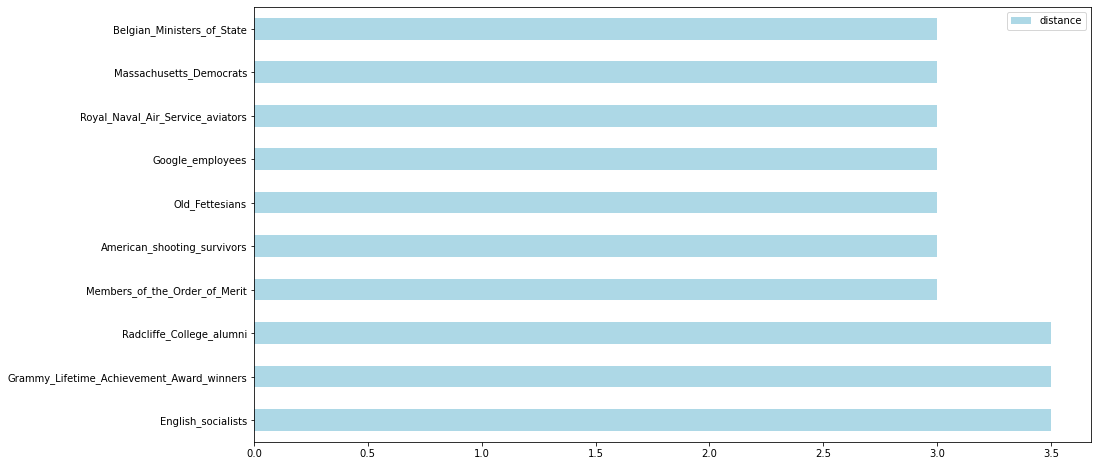

In [231]:
df_rq5 = pd.DataFrame(d, index = ['distance']).T
df_rq5.head(10).sort_values(by = 'distance', ascending = False).plot.barh(figsize = (15,8),color = 'lightblue');

Here we provide a more general overview of the distance ditribution of the categories. We can obeserve that from the category *Naturalised_citizens_of_the_United_Kingdom* we reach over half of the connected categories within 10 clicks. A peculiar aspect of this distribution is that is is not uniform, more specifically we can notice that there are three "clusters". We may address this peculiar feature to the fact that, when one node in a category (C0) has a greater distance from another node in a different category (Ci), also all the other nodes in C0 are more likely to be at a greater distance from any node in Ci.

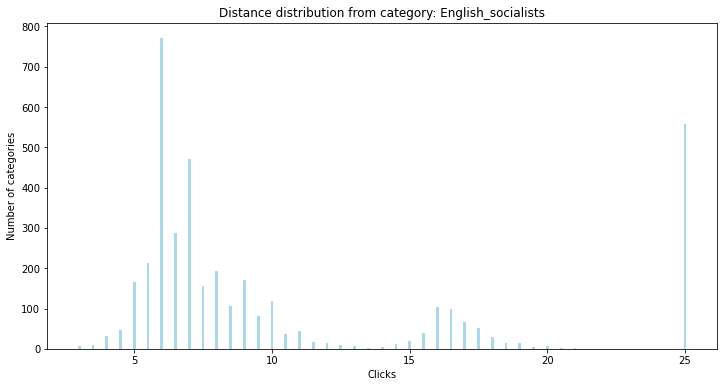

In [232]:
distances = list(d.values())
dist_plot = []
for dist in set(distances):
    dist_plot.append(distances.count(dist))
plt.figure(figsize=(12,6))
plt.bar(list(set(distances)),dist_plot,color = 'lightblue',width = 0.1);
plt.ylabel('Number of categories')
plt.xlabel('Clicks')
plt.title(f'Distance distribution from category: {c0}')
plt.show()

## RQ6
To complete this task we will, at first, transform our graph into one which has the nodes' categories as nodes. In short, for each category we merge the sets of nodes associated to any of the nodes of that category. In order to keep all the information from the previous graph we decided to transform our unweighted graph to a weighted one. The weight will be the number of nodes that have in/out links from/to another category. We provide an example of the graph structure below.

In [211]:
in_links_cat = transform(in_links)
out_links_cat = transform(out_links)
in_links_cat['Telugu-language_films']

{'2000s_drama_films': 2,
 'Indian_films': 46,
 'Black-and-white_films': 3,
 'Tamil_actors': 1,
 'Year_of_birth_missing_(living_people)': 5,
 'Telugu-language_films': 21,
 '2000s_romance_films': 1,
 'Bengali-language_films': 2,
 '1979_films': 1,
 'Tulu_people': 1,
 'Hindi-language_films': 8,
 '2010_films': 8,
 '1976_films': 1,
 'Indian_actors': 6,
 'Film_scores': 1,
 'Indian_film_singers': 2,
 '2002_films': 2,
 'Year_of_birth_missing': 6,
 '2006_films': 7,
 '2010s_action_films': 2,
 'People_from_Baltimore,_Maryland': 1,
 '1968_films': 1,
 'Telugu_actors': 2,
 'Tamil-language_films': 9,
 '2011_films': 2,
 'Living_people': 6,
 '2007_films': 5,
 '2008_films': 4,
 '1978_films': 2,
 '2005_films': 1}

We implemented the *random walk* version of the pagerank algorithm with a probabilistic approach. Since the importance of a web page can be measured by how many incoming links it has, we can see the importance of page as the probability that a random surfer on the Internet opens any page. We can interpret the weights in a probabilistic way, meaning that a greater weight increases the probability that the surfer will visit a certain page. We can model the process as a random walk on graphs. \
At the beginning, each page has equal probability to be chosen as a starting point. So, the initial probability is given by a vector which has all values $\frac{1}{n°nodes}$. The probability that page i will be visited after k steps is equal to its ranking score after k iterations. How do we determine the ranking score on a node N1 at iteration k? 
- For each node (N1) we check which nodes have an outlink to this node; 
- For each of these nodes (N2) we calculate the probability of N1 to receive a node from N2 and multiply it by the ranking score of N2 of the previous iteration, more specifically the probability that N1 recieves a link from N2 is: 
    $P_{N2} = \frac{W_{N2}}{\sum_{i=1}^{In} W_i}$
    where *In* is the number of in-links of N1 and $W_i$ is the weight of each in-link of N1.
- The score of N1 at a given iteration will be $\sum_{i=1}^{In} P_{Ni}$

CPU times: user 2min 31s, sys: 7.97 ms, total: 2min 31s
Wall time: 2min 31s


<AxesSubplot:>

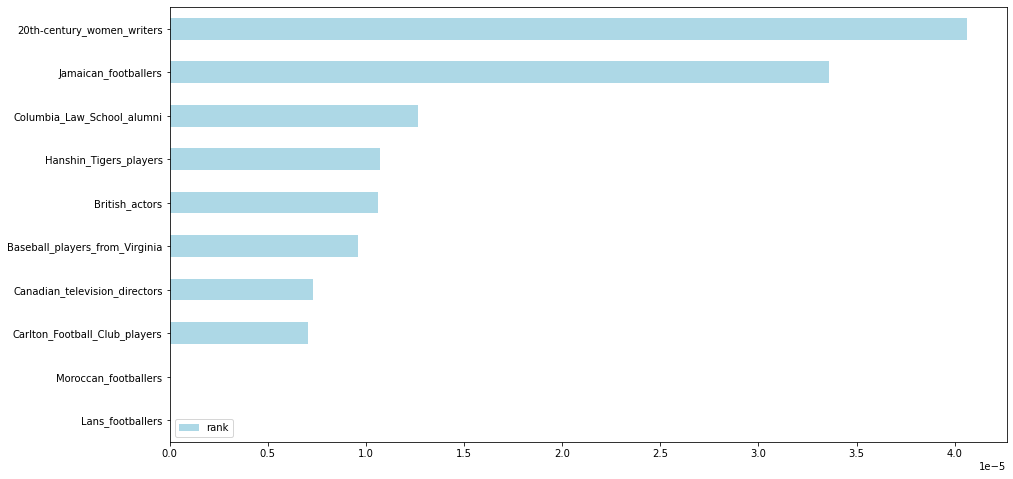

In [210]:
%%time
rank = pagerank(25)
df_rq6 = pd.DataFrame(rank, index = ['rank']).T
df_rq6.head(10).sort_values(by = 'rank', ascending = True).plot.barh(figsize = (15,8),color = 'lightblue');

In [201]:
%%time
rank = pagerank(100)
df_rq6 = pd.DataFrame(rank, index = ['rank']).T
df_rq6.head(10).sort_values(by = 'rank', ascending = True).plot.barh(figsize = (15,8),color = 'lightblue');

0.9999999999999966
CPU times: user 9min 37s, sys: 11.9 ms, total: 9min 37s
Wall time: 9min 37s


## To copy in python script

In [203]:
####################################### RQ5 ##########################################
def categories_distance(c1):
    
    c1_nodes = [int(i) for i in category_nodes[c1]] # int casting needed for comparison
    distances_dict = {k: [] for k in category_nodes.keys()}
    t = []
    
    '''
    1. We consider the exploration tree of each node in c1 with the exploration function defined above. 
    2. For each category c2 we save a list of distances between any node in c2 (node2) and node1.
    3. For a new node in c1 (node1), we will keep updating the list of distances for each category c2.
       If any node in c2 is disconnected from node1 (not in node1 tree) we consider it to be at a distance
       from equal to the max distance of node1 tree + 1.
    4. Finally, we will take the median of distances for each category and sort the dictionary.
    '''
    
    #step 1
    for node1 in c1_nodes:
        if node1 in out_links.keys():
            distance_tree = explore(node1,None)
            t.append(max(list(distance_tree.keys())) + 1)
    #step 2
            for cat in category_nodes.keys():  
                dist = []
                disconnected = []
                for node1_dist in distance_tree.keys():
                    c2_nodes = [int(i) for i in category_nodes[cat]]
                    nodes_in_tree = len(set(c2_nodes).intersection(set(distance_tree[node1_dist])))
                    dist += [node1_dist]*nodes_in_tree # number of nodes at distance d x distance d
    # step 3
                disconnected = [max(distance_tree.keys())+1]*(len(c2_nodes)-len(dist)) 
                distances_dict[cat] += dist + disconnected
    # step 4
    for key in distances_dict.keys():
        distances_dict[key] = statistics.median(distances_dict[key])
    
    distances_dict = {k: v for k, v in sorted(distances_dict.items(), key=lambda item: item[1])}
    threshold = statistics.median(t)
    d_filt= {k: v for k,v in distances_dict.items() if distances_dict[k] < threshold}
    
    return d_filt 

####################################### RQ6 ##########################################


def transform(links):
    
    ''' We transform our graph into one which has categories as nodes. 
    In order to do this we consider the inlinks and outlinks of each node separately.
    1. For each category we concatenate the nodes associated to any of the nodes of that category.
    2. We weight links by counting how many nodes in a category are linked to another node (or other nodes)
    in another category.'''
    
    links_cat = {k: [] for k in category_nodes.keys()}
    
    for node in nodes_category.keys():
        if int(node) in links.keys():
            for link in links[int(node)]:
                if link in nodes_category.keys():
                    if links_cat[nodes_category[node]] != nodes_category[link]:    # to avoid selflinks
                        links_cat[nodes_category[node]].append(nodes_category[link])

    for cat in links_cat.keys():
        categories = {}
        to_transform = set(links_cat[cat])
        for node in to_transform:
            categories[node] = links_cat[cat].count(node)
        links_cat[cat] = categories
                                     
    return links_cat

def pagerank(n_iter):
    
    ''' INITIALIZATION
    This page rank algorithm initialize the ranking vector assuming that all pages have the same importance.
    1. we store a list of category names with fixed index that we use for the ranking vector
    2. we initalize all values as 1 / number of nodes
    '''
    categories_names = list(set(in_links_cat.keys()).union(set(out_links_cat.keys())))
    init = [1/len(categories_names)]*len(categories_names)
    
    
    ''' ITERATIONS
    1. At each iteration we initalize a new vector to store the ranking score of each node.
    2. For each node we initialize a 0 score and save the nodes (In) that have an outlink to that node (node1).
    3. For each node (node2) that has an outlink to the analyzed node (node1), we define:
        a) Probability : probability that node1 is reached through node2
        b) Rank : rank score of node2 in the previous iteration
    4. We multiply probability of node 2 by its ranking score
    5. We sum this score for all nodes in In and assign this final score to the position of node1 in the rank vector.
    6. We update init vector.
     '''
    for i in range(n_iter):
        new_iter = [0]*len(categories_names)
        for node1 in categories_names:
            score = 0
            pos1 = categories_names.index(node1)
            if node1 in in_links_cat.keys():        # not all nodes have in_links
                In = in_links_cat[node1]
                for node2 in In:
                    pos2 = categories_names.index(node2)
                    prob2 = out_links_cat[node2][node1]/sum(out_links_cat[node2].values())
                    rank2 = init[pos2]
                    score += rank2*prob2
            new_iter[pos1] = score
        init = [float(i)/sum(new_iter) for i in new_iter]
        
    return dict(zip(categories_names,init))